In [1]:
#Importando Paquetes


import pandas as pd
import seaborn as sns
from IPython.display import display
import numpy as np
import math



from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]


import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Leyendo datos
df= pd.read_csv("C:/Users/LUISPEDRO/Desktop/Universidad Del Valle/Semestre 7/InteligenciaArtificial/Lab2/Walmart.csv")



## Exploración de datos

In [3]:
#Explorando un poco el dataframe... se ven 8 columnas con 6435 entradas
display(df.head())
print("Hay ", df.shape[0], " entradas")




,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


Hay  6435  entradas


In [4]:
#Trabajar con los dias, meses y anios por separado
#El dia de la semana se trabaja desde 0 a 6 (Lunes a domingo)

df.Date=pd.to_datetime(df.Date)

df['diaSemanal'] = df.Date.dt.weekday
df['mes'] = df.Date.dt.month
df['anio'] = df.Date.dt.year

df.drop(['Date'], axis=1, inplace=True)



In [5]:
#Isolando las columnas que no entran a nuestra predicción
prediccion = 'Weekly_Sales'
columnas = [i for i in df.columns if i not in [prediccion]]
original_df = df.copy(deep=True)

df.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,diaSemanal,mes,anio
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,6,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,3,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,4,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,4,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,0,5,2010


In [6]:
#Numericas y Categoricas

unico = df[columnas].nunique().sort_values()
numerico= []
categorico = []
for i in range(df[columnas].shape[1]):
    if unico.values[i]<=45:
        categorico.append(unico.index[i])
    else: 
        numerico.append(unico.index[i])

print('Las variables numericas son', numerico)
print('Las variables categoricas son', categorico)


Las variables numericas son ['Unemployment', 'Fuel_Price', 'CPI', 'Temperature']
Las variables categoricas son ['Holiday_Flag', 'anio', 'diaSemanal', 'mes', 'Store']


In [7]:
#Breve análisis estadístico

display(df.describe())

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,diaSemanal,mes,anio
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151,3.573427,6.475524,2010.965035
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885,1.426581,3.321797,0.797019
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000,0.000000,1.000000,2010.000000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000,4.000000,4.000000,2010.000000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000,4.000000,6.000000,2011.000000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000,4.000000,9.000000,2012.000000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000,6.000000,12.000000,2012.000000


## Preprocesamiento

In [8]:
#Buscando NA, NaN o NULL, ya que puede traer problemas

nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Nulls Total'])
nulls['%'] = round(nulls['Nulls Total']/df.shape[0],3)*100
print(nulls)

              Nulls Total    %
Store                   0  0.0
Weekly_Sales            0  0.0
Holiday_Flag            0  0.0
Temperature             0  0.0
Fuel_Price              0  0.0
CPI                     0  0.0
Unemployment            0  0.0
diaSemanal              0  0.0
mes                     0  0.0
anio                    0  0.0


In [11]:
#Convertir Categorico a numerico

df2 = df.copy()
val = nulls[nulls['%']!=0].index.values
cate = [i for i in categorico if i not in val]



for i in cate:
    if (df2[i].nunique()>2):
        df2 = pd.concat([df2.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df2[i], drop_first=True, prefix=str(i)))],axis=1)
        

In [12]:
#Atípicos

df1 = df2.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = numerico

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())

a = int(format(df2.shape[0]))
b= int(format(df1.shape[0]))

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

print('Se removieron', a-b, 'valores')


,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,anio_2011,anio_2012,diaSemanal_1,diaSemanal_2,...,Store_36,Store_37,Store_38,Store_39,Store_40,Store_41,Store_42,Store_43,Store_44,Store_45
0,1643690.90,0,42.31,2.572,211.096358,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1641957.44,1,38.51,2.548,211.242170,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1611968.17,0,39.93,2.514,211.289143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1409727.59,0,46.63,2.561,211.319643,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1554806.68,0,46.50,2.625,211.350143,8.106,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Se removieron 482 valores


## Spliting de test y train

In [13]:
#Se divide en 70% train 30% test
m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([prediccion],axis=1)
Y = df[prediccion]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.7, test_size=0.3, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

#Estándarizacion con StandardScaler

std = StandardScaler()
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)


Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)

In [14]:
#Eliminamos Multicolinealidad modelo Recursive Feature Elimination
Mr=[]
Ms=[]
n=3
order=['ord-'+str(i) for i in range(2,n)]
Mrd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Msd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)            
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Mr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Ms.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

## Modelo Predictivo

In [18]:
#Funcion para evaluar el modelo polinomial
#Referencia: https://www.kaggle.com/yasserh/walmart-sales-prediction-best-ml-algorithms?

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluación de modelo multiple linear

    print('Metricas Train')
    print('')                                                               
    print('R2 Train: ',round(r2_score(Train_Y, pred1),20))
    print('RSS Train: ',round(np.sum(np.square(Train_Y-pred1)),20))
    print('MSE Train: ',round(mean_squared_error(Train_Y, pred1),20))
    print('RMSE Train',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))
    print('')
    print('')                                                                         
                                                                            
                                                                            

    print('Metricas Test'.format('-'*20, '-'*20))
    print('')                                                                         
    print('R2 Test',round(r2_score(Test_Y, pred2),20))
    print('RSS Test',round(np.sum(np.square(Test_Y-pred2)),20))
    print('MSE Test',round(mean_squared_error(Test_Y, pred2),20))
    print('RMSE Test',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('')                                                                         
    print('Residuales'.format('-'*20, '-'*20))

    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)
    
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Terminos de Error')          
    plt.xlabel('Errores') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediccion')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

REGRESION LINEAL EVALUACION
El intercepto es 1051376.4668682504


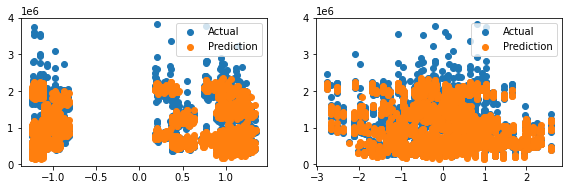

Metricas Train

R2 Train:  0.9314915051444052
RSS Train:  93712862116512.94
MSE Train:  22489287764.94191
RMSE Train 149964.28829872102


Metricas Test

R2 Test 0.9341050466073191
RSS Test 38277243532268.875
MSE Test 21431827285.704857
RMSE Test 146396.13138913494

Residuales


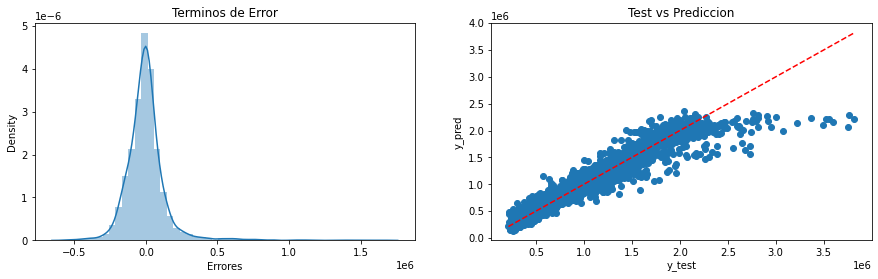

In [19]:
#Regresion Lineal
#Referencia: https://www.kaggle.com/yasserh/walmart-sales-prediction-best-ml-algorithms?

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('REGRESION LINEAL EVALUACION'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('El intercepto es',MLR.intercept_)

Evaluate(0, pred1, pred2)

In [20]:
#Regresion Polinomial 
#Referencia:https://www.kaggle.com/yasserh/walmart-sales-prediction-best-ml-algorithms
#Probando en distintos grados de polinomio

Mr=[]
Ms=[]
n_degree=4

for i in range(2,n_degree):
    #Usando grado "i"
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Mr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Ms.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Mr, label='Train')
plt.plot(range(2,n_degree),Ms, label='Test')
plt.title('Regresion Polinomial Fit')
plt.xlabel('Grado')
plt.ylabel('RMSE')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Mr, label='Train')
plt.plot(range(2,n_degree),Ms, label='Test')
plt.title('Regresion Polinomial Fit')
plt.ylim([0,2e16])
plt.xlabel('Grado')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
plt.show()

KeyboardInterrupt: 

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [   4498.62265778  -11075.62432318    7066.05940237  505840.87306112
  -63510.02894371  -33828.51320496  -75305.48428742    6114.11295338
  -11249.74855585  -13310.85817916  -15384.99549735  -12390.02141332
   -1601.36765148   28292.38296019   19831.79737939   20016.01149565
   20552.6192013    30534.68066849   17883.8399359    22827.91481527
   10212.51515641   14657.27496984   41651.44751116   62503.35100747
   58557.52415362 -186978.320816    223406.26701327 -193199.32152548
  -10194.67931491  -98787.66975191 -121218.30001673 -164081.83244451
  231514.8783389   -39237.70954107   44791.66684258  229805.1553985
  140779.56849458   16751.33306115 -126137.29132396   61310.84925601
   95901.86155741  140967.4030308    95558.30332554 -124422.90927619
   76356.60000744   96649.23346954  133359.83861802 -125020.72498775

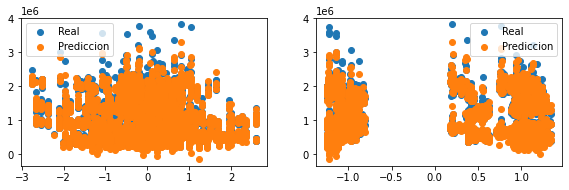

Metricas Train
 
R2:  0.9789127398840983
RMSE Train:  83200.45768092015
 
 
 
Metricas Test
 
 
R2:  -1.3072029086014145e+23
RMSE Test:  2.0619352611114698e+17
Residuales


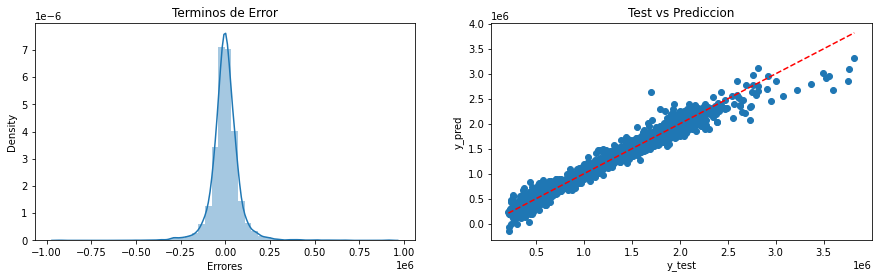

In [89]:
#Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('Evaluando la regresión polinomial)

print('Intercepto',MLR.intercept_)

Evaluate(2, pred1, pred2)